<a href="https://colab.research.google.com/github/Sharan-Babu/ImageDehazingWithCycleGANs/blob/main/SIREN_Haze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd gdrive

/content/gdrive


In [ ]:
cd My Drive

/content/gdrive/My Drive


In [ ]:
cd Cycle-Dehaze-master/

/content/gdrive/.shortcut-targets-by-id/110KC63E-AAZwvWfMcABxZ5H6o87zoNNL/Cycle-Dehaze-master


In [ ]:
ls

AtoB_generated_plot_003500.png  g_model_BtoA_003000.h5
BtoA_generated_plot_008000.png  g_model_BtoA_003500.h5
build_data.py                   g_model_BtoA_008000.h5
c_model_AtoB_1.h5               haze_8_28_repo_mod_1.ipynb
c_model_BtoA_1.h5               haze.tfrecords
convertHazy2GT.sh               inference.py
create_model.sh                 laplacian.m
dehaze.npz                      LICENSE
demo.sh                         logs/
discriminator.py                model.py
d_model_A_1.h5                  models/
d_model_B_1.h5                  OHaze/
export_graph.py                 ops.py
figs/                           Outdoor.ipynb
generator.py                    __pycache__/
g_model_AtoB_000500.h5          reader.py
g_model_AtoB_001000.h5          reader_report.txt
g_model_AtoB_001500.h5          reader_v2.py
g_model_AtoB_002000.h5          README.md
g_model_AtoB_002500.h5          resize_im.m
g_model_AtoB_003000.h5          results/
g_model_AtoB_003500.h5          train.py
g_model

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-etlz9ter
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-etlz9ter
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=814f42390cf8108de33b6c2afebcf7cd79c8dc47c8d0f0a7b315ae56c4ce4a93
  Stored in directory: /tmp/pip-ephem-wheel-cache-8bfxtpkt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
!pip install --upgrade tf_siren

Requirement already up-to-date: tf_siren in /usr/local/lib/python3.6/dist-packages (0.0.5)


In [ ]:
from tf_siren import SinusodialRepresentationDense
from tf_siren import SIRENModel

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [ ]:
image_shape = (256,256,3)
model = define_discriminator(image_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(n_filters,activation='sine',w0=1.0)(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(64,activation='sine',w0=1.0)(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(128,activation='sine',w0=1.0)(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(256,activation='sine',w0=1.0)(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(128,activation='sine',w0=1.0)(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)
    g = SinusodialRepresentationDense(64,activation='sine',w0=1.0)(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model       

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10],
                  optimizer=opt)
    return model

In [ ]:
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
c_model_AtoBtoA = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoAtoB = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape,1))
    return X,y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
pwd

'/content/gdrive/.shortcut-targets-by-id/110KC63E-AAZwvWfMcABxZ5H6o87zoNNL/Cycle-Dehaze-master'

In [ ]:
from tf_siren import Sine
from tf_siren import SIRENInitializer
from tf_siren import SIRENFirstLayerInitializer

In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
cust = {
    'Sine': Sine,
    'SIRENInitializer': SIRENInitializer,
    'SIRENFirstLayerInitializer': SIRENFirstLayerInitializer,
    'SinusodialRepresentationDense': SinusodialRepresentationDense,
    'InstanceNormalization': InstanceNormalization
}

In [ ]:
import keras
keras.utils.get_custom_objects().update({
    'Sine': Sine,
    'SIRENInitializer': SIRENInitializer,
    'SIRENFirstLayerInitializer': SIRENFirstLayerInitializer,
    'SinusodialRepresentationDense': SinusodialRepresentationDense,
    'InstanceNormalization': InstanceNormalization
})

In [ ]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
AtoB_generated_plot_003500.png  g_model_BtoA_003000.h5
BtoA_generated_plot_008000.png  g_model_BtoA_003500.h5
build_data.py                   g_model_BtoA_008000.h5
c_model_AtoB_1.h5               haze_8_28_repo_mod_1.ipynb
c_model_BtoA_1.h5               haze.tfrecords
convertHazy2GT.sh               inference.py
create_model.sh                 laplacian.m
dehaze.npz                      LICENSE
demo.sh                         logs/
discriminator.py                model.py
d_model_A_1.h5                  models/
d_model_B_1.h5                  OHaze/
export_graph.py                 ops.py
figs/                           Outdoor.ipynb
generator.py                    __pycache__/
g_model_AtoB_000500.h5          reader.py
g_model_AtoB_001000.h5          reader_report.txt
g_model_AtoB_001500.h5          reader_v2.py
g_model_AtoB_002000.h5          README.md
g_model_AtoB_0025

In [ ]:
from keras.models import load_model
d_model_A = load_model('d_model_A_1.h5')

In [ ]:
d_model_B = load_weights('d_model_B_1.h5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-a57df878c612>", line 1, in <module>
    d_model_B = load_weights('d_model_B_1.h5')
NameError: name 'load_weights' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-package

NameError: ignored

In [ ]:
#from keras.models import load_model
d_model_A = load_model('d_model_A_1.h5')
d_model_B = load_model('d_model_B_1.h5')
c_model_AtoB = load_model('c_model_AtoB_1.h5')
c_model_BtoA = load_model('c_model_BtoA_1.h5')
g_model_AtoB = load_model('g_model_AtoB_003500.h5')
g_model_BtoA = load_model('g_model_BtoA_003500.h5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-985dcc386f55>", line 6, in <module>
    g_model_AtoB = load_model('g_model_AtoB_003500.h5')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/saving/save.py", line 205, in load_model
    (isinstance(filepath, h5py.File) or h5py.is_hdf5(filepath))):
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/base.py", line 41, in is_hdf5
    fname = os.path.abspath(fspath(fname))
  File "/usr/lib/python3.6/posixpath.py", line 383, in abspath
    cwd = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_tr

FileNotFoundError: ignored

In [ ]:
# dont run
d_model_A.save('d_model_A_1.h5')
d_model_B.save('d_model_B_1.h5')
c_model_AtoB.save('c_model_AtoB_1.h5')
c_model_BtoA.save('c_model_BtoA_1.h5')

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
# select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,
dataset):
    # define properties of the training run
    n_epochs, n_batch, = 200, 1                                   # I changed n_epochs from 100 to 1 and n_batch to 1 from 150
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
# select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
# generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
# update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
            X_realA, X_realB, X_realA])
# update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
# update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
            X_realB, X_realA, X_realB])
# update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
# summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2,
            dB_loss1,dB_loss2, g_loss1,g_loss2))
# evaluate the model performance every so often
        if (i+1) % (500) == 0:
# plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
# plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (500) == 0:                                   # changed from (bat_per_epo * 5) to (bat_per_epo * 1)
# save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# only once per day
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

def load_images(path, size=(256,256)):
    data_list = list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    return asarray(data_list)

path = 'OHaze/'
dataA1 = load_images(path + 'haze/')
dataAB = load_images(path + 'validation/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
dataB1 = load_images(path + 'Clear/')
dataB2 = load_images(path + 'Clear_test/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
filename = 'dehaze.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (40, 256, 256, 3)
Loaded dataB:  (40, 256, 256, 3)
Saved dataset:  dehaze.npz


Loaded:  (40, 256, 256, 3) (40, 256, 256, 3)


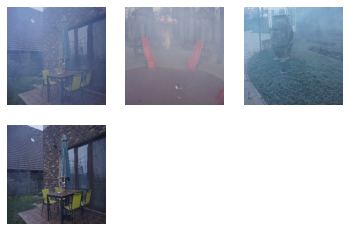

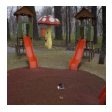

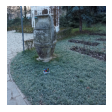

In [ ]:
from numpy import load
from matplotlib import pyplot
data = load('dehaze.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
    pyplot.show()

In [ ]:
# load image data
dataset = load_real_samples('dehaze.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Loaded (40, 256, 256, 3) (40, 256, 256, 3)


In [ ]:
def select_sample(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [ ]:
h = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[2.715,0.785] dB[0.990,0.723] g[17.332,20.512]
>2, dA[12.858,0.680] dB[1.437,0.762] g[16.582,17.787]
>3, dA[16.054,0.657] dB[10.699,0.764] g[16.996,17.716]
>4, dA[4.007,0.539] dB[1.788,0.769] g[17.553,17.151]
>5, dA[2.775,0.613] dB[0.980,0.839] g[17.248,16.853]
>6, dA[2.321,0.558] dB[1.014,0.668] g[17.325,16.982]
>7, dA[0.961,0.703] dB[1.268,0.658] g[16.007,16.452]
>8, dA[0.795,0.648] dB[1.898,0.583] g[16.960,17.442]
>9, dA[0.792,0.622] dB[2.622,0.610] g[16.501,16.138]
>10, dA[0.546,0.641] dB[1.224,0.881] g[16.763,16.329]
>11, dA[1.066,0.605] dB[0.990,0.697] g[16.885,16.769]
>12, dA[1.057,0.854] dB[1.548,0.688] g[16.926,17.710]
>13, dA[1.041,0.573] dB[2.324,0.579] g[16.480,17.004]
>14, dA[0.706,1.143] dB[1.065,0.616] g[16.675,17.851]
>15, dA[0.490,0.510] dB[0.811,0.515] g[16.000,16.073]
>16, dA[0.836,0.595] dB[0.746,0.545] g[16.885,16.857]
>17, dA[0.506,0.551] dB[0.912,0.512] g[16.113,16.124]
>18, dA[0.523,0.623] dB[0.941,0.522] g[18.140,17.416]
>19, dA[0.551,0.544] dB[1.090,0.61

KeyboardInterrupt: ignored

In [ ]:
h = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.005,0.005] dB[0.001,0.001] g[6.353,5.607]
>2, dA[0.002,0.002] dB[0.001,0.001] g[4.909,4.605]
>3, dA[0.024,0.013] dB[0.001,0.001] g[7.040,8.090]
>4, dA[0.022,0.004] dB[0.000,0.001] g[4.655,5.517]
>5, dA[0.004,0.009] dB[0.001,0.002] g[5.201,5.755]
>6, dA[0.008,0.004] dB[0.001,0.001] g[2.878,3.268]
>7, dA[0.007,0.002] dB[0.000,0.000] g[4.564,4.568]
>8, dA[0.002,0.005] dB[0.001,0.001] g[4.719,4.508]
>9, dA[0.003,0.003] dB[0.001,0.001] g[6.301,5.934]
>10, dA[0.003,0.002] dB[0.002,0.002] g[6.408,7.021]
>11, dA[0.009,0.004] dB[0.002,0.001] g[5.203,4.982]
>12, dA[0.003,0.003] dB[0.001,0.001] g[4.052,4.176]
>13, dA[0.004,0.002] dB[0.002,0.001] g[6.004,5.966]
>14, dA[0.003,0.001] dB[0.000,0.001] g[4.835,5.055]
>15, dA[0.003,0.001] dB[0.002,0.003] g[5.222,4.955]
>16, dA[0.002,0.002] dB[0.002,0.001] g[7.348,8.021]
>17, dA[0.002,0.003] dB[0.001,0.001] g[5.012,5.257]
>18, dA[0.003,0.003] dB[0.000,0.000] g[4.423,4.369]
>19, dA[0.002,0.002] dB[0.000,0.000] g[4.467,4.524]
>20, dA[0.006,0.002] 

In [ ]:
A_data, B_data = load_real_samples('dehaze.npz')
print('Loaded', A_data.shape, B_data.shape)
cust = {'InstanceNormalization': InstanceNormalization}

Loaded (40, 256, 256, 3) (40, 256, 256, 3)


In [ ]:
A_real = select_sample(A_data, 1)
B_generated = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)

In [ ]:
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    images = (images + 1) / 2.0
    for i in range(len(images)):
        pyplot.subplot(1, len(images), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
    pyplot.show()

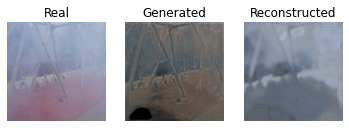

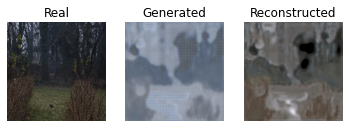

In [ ]:
from numpy import vstack
show_plot(A_real, B_generated, A_reconstructed)    
B_real = select_sample(B_data, 1)
A_generated = g_model_BtoA.predict(B_real)
B_reconstructed = g_model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

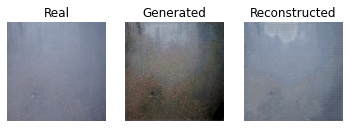

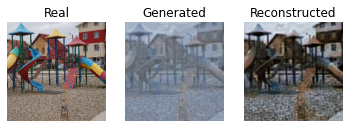

In [ ]:
A_real = select_sample(A_data, 1)
B_generated = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)
from numpy import vstack
show_plot(A_real, B_generated, A_reconstructed)    
B_real = select_sample(B_data, 1)
A_generated = g_model_BtoA.predict(B_real)
B_reconstructed = g_model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
#3500